# Abundance zeropoint analysis

## Author(s): Sven Buder (SB, WG4)

### History:
180926 SB Created

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import collections
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from astropy.table import Table
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

# Sun (reference: Asplund et al. 2009)

In [2]:
sun = collections.OrderedDict()

sun['teff'] = [5772., 0.00] # Prsa et al., 2016, AJ, 152, 41
sun['logg'] = [4.44, 0.00] # Prsa et al., 2016, AJ, 152, 41
sun['fe_h'] = [0.00, 0.00]
sun['fe_h_atmo'] = [0.00, 0.00]
sun['vmic'] = [1.06 , 0.00] # GBS
sun['vbroad'] = [np.sqrt(4.00**2. + 1.6**2.),0.00] # GBS
sun['mass'] = [1.00 , 0.00] # by definition
sun['lbol'] = [1.00 , 0.00] # by definition
sun['age']  = [4.57 , 0.11] # Bonanno et al., 2002, A&A, 390, 1115
sun['alpha_fe']  = [0.00 , 0.00]

# Asplund+2009 Z, A_X, e_A_X
# sun["A_Li"] = [1.05, 0.10,  3]
# sun["A_C"]  = [8.43, 0.05,  6]
# sun["A_O"]  = [8.69, 0.05,  8]
# sun["A_Na"] = [6.24, 0.04, 11]
# sun["A_Mg"] = [7.60, 0.04, 12]
# sun["A_Al"] = [6.45, 0.03, 13]
# sun["A_Si"] = [7.51, 0.03, 14]
# sun["A_K"]  = [5.03, 0.09, 19]
# sun["A_Ca"] = [6.34, 0.04, 20]
# sun["A_Sc"] = [3.15, 0.04, 21]
# sun["A_Ti"] = [4.95, 0.05, 22]
# sun["A_V"]  = [3.93, 0.08, 23]
# sun["A_Cr"] = [5.64, 0.04, 24]
# sun["A_Mn"] = [5.43, 0.04, 25]
# sun["A_Fe"] = [7.50, 0.04, 26]
# sun["A_Co"] = [4.99, 0.07, 27]
# sun["A_Ni"] = [6.22, 0.04, 28]
# sun["A_Cu"] = [4.19, 0.04, 29]
# sun["A_Zn"] = [4.56, 0.05, 30]
# sun["A_Rb"] = [2.52, 0.10, 37]
# sun["A_Sr"] = [2.87, 0.07, 38]
# sun["A_Y"]  = [2.21, 0.05, 39]
# sun["A_Zr"] = [2.58, 0.04, 40]
# sun["A_Mo"] = [1.88, 0.08, 42]
# sun["A_Ru"] = [1.75, 0.08, 44]
# sun["A_Ba"] = [2.18, 0.09, 56]
# sun["A_La"] = [1.10, 0.04, 57]
# sun["A_Ce"] = [1.58, 0.04, 58]
# sun["A_Nd"] = [1.42, 0.04, 60]
# sun["A_Sm"] = [0.96, 0.04, 62]
# sun["A_Eu"] = [0.52, 0.04, 63]

# Grevesse
sun["A_Li"] = [1.05, 0.00,  3]
sun["A_C"]  = [8.39, 0.00,  6]
sun["A_O"]  = [8.66, 0.00,  8]
sun["A_Na"] = [6.17, 0.00, 11]
sun["A_Mg"] = [7.53, 0.00, 12]
sun["A_Al"] = [6.37, 0.00, 13]
sun["A_Si"] = [7.51, 0.00, 14]
sun["A_K"]  = [5.08, 0.00, 19]
sun["A_Ca"] = [6.31, 0.00, 20]
sun["A_Sc"] = [3.17, 0.00, 21]
sun["A_Ti"] = [4.90, 0.00, 22]
sun["A_V"]  = [4.00, 0.00, 23]
sun["A_Cr"] = [5.64, 0.00, 24]
sun["A_Mn"] = [5.39, 0.00, 25]
sun["A_Fe"] = [7.45, 0.00, 26]
sun["A_Co"] = [4.92, 0.00, 27]
sun["A_Ni"] = [6.23, 0.00, 28]
sun["A_Cu"] = [4.21, 0.00, 29]
sun["A_Zn"] = [4.60, 0.00, 30]
sun["A_Rb"] = [2.60, 0.00, 37]
sun["A_Sr"] = [2.92, 0.00, 38]
sun["A_Y"]  = [2.21, 0.00, 39]
sun["A_Zr"] = [2.58, 0.00, 40]
sun["A_Mo"] = [1.92, 0.00, 42]
sun["A_Ru"] = [1.84, 0.00, 44]
sun["A_Ba"] = [2.17, 0.00, 56]
sun["A_La"] = [1.13, 0.00, 57]
sun["A_Ce"] = [1.70, 0.00, 58]
sun["A_Nd"] = [1.45, 0.00, 60]
sun["A_Sm"] = [1.00, 0.00, 62]
sun["A_Eu"] = [0.52, 0.00, 63]

# Arcturus (reference: internal APOGEE values, Ramirez & Allende Prieto 2011)

In [3]:
arcturus = collections.OrderedDict()

arcturus['teff'] = [4286, 35] # Heiter et al., 2005, A&A, 582, 49
arcturus['logg'] = [1.60, 0.20] # Heiter et al., 2005, A&A, 582, 49
arcturus['fe_h'] = [-0.52, 0.08] # Heiter et al., 2005, A&A, 582, 49
arcturus['fe_h_atmo'] = [-0.52, 0.08] # Heiter et al., 2005, A&A, 582, 49
arcturus['vmic'] = [1.25 , 0.00] 
arcturus['vbroad'] = [np.sqrt(5.07**2. + 3.8**2.), 0.00] 
arcturus['mass'] = [1.08 , 0.06] # Ramirez & Allende Prieto, 2011, ApJ, 743, 135
arcturus['lbol'] = [197.2, 2.2] # Heiter et al., 2005, A&A, 582, 49
arcturus['age']  = [7.1, 1.5] # Ramirez & Allende Prieto, 2011, ApJ, 743, 135
arcturus['alpha_fe']  = [0.20 , 0.00]

# Values from internal APOGEE communication, errors assumed to be 0.03!

arcturus["A_Li"] = [0.53, 0.03,  3]
arcturus["A_C"]  = [8.03, 0.03,  6]
arcturus["A_O"]  = [8.63, 0.03,  8]
arcturus["A_Na"] = [5.76, 0.03, 11]
arcturus["A_Mg"] = [7.38, 0.03, 12]
arcturus["A_Al"] = [6.19, 0.03, 13]
arcturus["A_Si"] = [7.32, 0.03, 14]
arcturus["A_K"]  = [4.76, 0.03, 19]
arcturus["A_Ca"] = [5.90, 0.03, 20]
arcturus["A_Sc"] = [2.80, 0.03, 21]
arcturus["A_Ti"] = [4.65, 0.03, 22]
arcturus["A_V"]  = [3.54, 0.03, 23]
arcturus["A_Cr"] = [5.07, 0.03, 24]
arcturus["A_Mn"] = [4.66, 0.03, 25]
arcturus["A_Fe"] = [6.93, 0.03, 26]
arcturus["A_Co"] = [4.49, 0.03, 27]
arcturus["A_Ni"] = [5.77, 0.03, 28]
arcturus["A_Cu"] = [3.71, 0.03, 29]
arcturus["A_Zn"] = [4.08, 0.03, 30]
arcturus["A_Rb"] = [2.08, 0.03, 37]
arcturus["A_Sr"] = [2.40, 0.03, 38]
arcturus["A_Y"]  = [1.69, 0.03, 39]
arcturus["A_Zr"] = [2.06, 0.03, 40]
arcturus["A_Mo"] = [1.40, 0.03, 42]
arcturus["A_Ru"] = [1.32, 0.03, 44]
arcturus["A_Ba"] = [1.65, 0.03, 56]
arcturus["A_La"] = [0.61, 0.03, 57]
arcturus["A_Ce"] = [0.99, 0.03, 58]
arcturus["A_Nd"] = [0.94, 0.03, 60]
arcturus["A_Sm"] = [0.48, 0.03, 62]
arcturus["A_Eu"] = [0.00, 0.03, 63]

# GALAH values

In [4]:
gbs_lbol     = pyfits.getdata('../gbs/data/GALAH_gbs_lbol.fits',1)
gbs_sun      = gbs_lbol[(gbs_lbol['sobject_id'] == 150405000901378)][0]
gbs_arcturus = gbs_lbol[(gbs_lbol['sobject_id'] == 150210005801171)][0]

In [5]:
galah_sun = collections.OrderedDict()

galah_sun['teff'] = [float('%.0f' % gbs_sun['TEFF']), float('%.0f' % gbs_sun['E_TEFF'])] 
galah_sun['logg'] = [float('%.2f' % gbs_sun['LOGG']), float(0.0)] 
galah_sun['fe_h'] = [float('%.2f' % gbs_sun['FEH']), float(0.0)] 
galah_sun['fe_h_atmo'] = [float('%.2f' % gbs_sun['FEH']), float(0.0)] 
galah_sun['vmic'] = [float('%.2f' % gbs_sun['VMIC']), float(0.0)] 
galah_sun['vbroad'] = [float('%.2f' % gbs_sun['VSINI']), float(0.0)] 
galah_sun['mass'] = [float('%.2f' % gbs_sun['MASS']), float(0.0)] 
galah_sun['lbol'] = [float('%.2f' % gbs_sun['LBOL']), float(0.0)] 
galah_sun['age']  = [float('%.2f' % gbs_sun['AGE']), float(0.0)] 
galah_sun['alpha_fe']  = [float('%.2f' % gbs_sun['ALPHA_FE']), float(0.0)] 
galah_sun['chi2_sp']  = [float('%.2f' % gbs_sun['CHI'][0]), float(0.0)]

# Z, A_X, e_A_X

for iterator, each_mode in enumerate(gbs_sun['MODE']):
    if (each_mode != 'Sp') & (len(each_mode) >=1):
        if (len(each_mode) <= 2):
            galah_sun["A_"+each_mode] = np.array([
                float('%.2f' % gbs_sun['A_ABUND'][iterator]), 
                float('%.2f' % gbs_sun['E_ABUND'][iterator])
            ])
        else:

            galah_sun["A_"+each_mode] = np.array([
                float('%.2f' % gbs_sun['A_ABUND'][iterator]), 
                float('%.2f' % gbs_sun['E_ABUND'][iterator])
            ])

            if each_mode == 'K7699':
                galah_sun["A_K"] = np.array([
                    float('%.2f' % gbs_sun['A_ABUND'][iterator]),
                    float('%.2f' % gbs_sun['E_ABUND'][iterator])
                ])

            if each_mode == 'Ca5862':
                galah_sun["A_Ca"] = np.array([
                    float('%.2f' % gbs_sun['A_ABUND'][iterator]),
                    float('%.2f' % gbs_sun['E_ABUND'][iterator])
                ])

            if each_mode == 'Cu5782':
                galah_sun["A_Cu"] = np.array([
                    float('%.2f' % gbs_sun['A_ABUND'][iterator]),
                    float('%.2f' % gbs_sun['E_ABUND'][iterator])
                ])

            if each_mode == 'Ba5854':
                galah_sun["A_Ba"] = np.array([
                    float('%.2f' % np.nanmean([gbs_sun['A_ABUND'][iterator],gbs_sun['A_ABUND'][iterator+1]])), 
                    float('%.2f' % np.nanmean([gbs_sun['E_ABUND'][iterator],gbs_sun['E_ABUND'][iterator+1]]))
                ])

In [6]:
galah_arcturus = collections.OrderedDict()

galah_arcturus['teff'] = ['%.0f' % gbs_arcturus['TEFF'], '%.0f' % gbs_arcturus['E_TEFF']] 
galah_arcturus['logg'] = ['%.2f' % gbs_arcturus['LOGG'], np.nan] 
galah_arcturus['fe_h'] = ['%.2f' % gbs_arcturus['FEH'], np.nan]
galah_arcturus['fe_h_atmo'] = ['%.2f' % gbs_arcturus['FEH'], np.nan]
galah_arcturus['vmic'] = ['%.2f' % gbs_arcturus['VMIC'], np.nan]
galah_arcturus['vbroad'] = ['%.2f' % gbs_arcturus['VSINI'], np.nan]
galah_arcturus['mass'] = ['%.2f' % gbs_arcturus['MASS'], np.nan] 
galah_arcturus['lbol'] = ['%.2f' % gbs_arcturus['LBOL'], np.nan] 
galah_arcturus['age']  = ['%.2f' % gbs_arcturus['AGE'], np.nan] 
galah_arcturus['chi2_sp']  = ['%.2f' % gbs_arcturus['CHI'][0], np.nan] 

# Z, A_X, e_A_X

for iterator, each_mode in enumerate(gbs_arcturus['MODE']):
    if (each_mode != 'Sp')  & (len(each_mode) <= 2) & (len(each_mode) >=1):
        galah_arcturus["A_"+each_mode] = np.array(
            ['%.2f' % gbs_arcturus['A_ABUND'][iterator],
             '%.2f' % gbs_arcturus['E_ABUND'][iterator],
             '%d' % gbs_arcturus['AFLAG'][iterator],
             '%.2f' % gbs_arcturus['LINEFLUX'][iterator],
             '%.2f' % gbs_arcturus['CHI'][iterator],
            ])
    else:
        if each_mode == 'K7699':
            galah_arcturus["A_K"] = np.array([
                '%.2f' % gbs_arcturus['A_ABUND'][iterator], 
                '%.2f' % gbs_arcturus['E_ABUND'][iterator]
            ])
        
        if each_mode == 'Ca5862':
            galah_arcturus["A_Ca"] = np.array([
                '%.2f' % gbs_arcturus['A_ABUND'][iterator],
                '%.2f' % gbs_arcturus['E_ABUND'][iterator]
            ])

        if each_mode == 'Cu5782':
            galah_arcturus["A_Cu"] = np.array([
                '%.2f' % gbs_arcturus['A_ABUND'][iterator],
                '%.2f' % gbs_arcturus['E_ABUND'][iterator]
            ])
            
        if each_mode == 'Ba5854':
            galah_arcturus["A_Ba"] = np.array([
                '%.0f' % np.nanmean([gbs_arcturus['A_ABUND'][iterator],gbs_arcturus['A_ABUND'][iterator+1]]), 
                '%.0f' % np.nanmean([gbs_arcturus['E_ABUND'][iterator],gbs_arcturus['E_ABUND'][iterator+1]])
            ])

In [7]:
for each_key in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age']:
    print(each_key,',',sun[each_key][0],'$\pm$',sun[each_key][1],',',galah_sun[each_key][0],'$\pm$',galah_sun[each_key][1])

teff , 5772.0 $\pm$ 0.0 , 5779.0 $\pm$ 104.0
logg , 4.44 $\pm$ 0.0 , 4.42 $\pm$ 0.0
fe_h , 0.0 $\pm$ 0.0 , 0.01 $\pm$ 0.0
fe_h_atmo , 0.0 $\pm$ 0.0 , 0.01 $\pm$ 0.0
vmic , 1.06 $\pm$ 0.0 , 1.16 $\pm$ 0.0
vbroad , 4.30813184571 $\pm$ 0.0 , 6.52 $\pm$ 0.0
mass , 1.0 $\pm$ 0.0 , 0.97 $\pm$ 0.0
lbol , 1.0 $\pm$ 0.0 , 1.01 $\pm$ 0.0
age , 4.57 $\pm$ 0.11 , 5.83 $\pm$ 0.0


In [8]:
for each_key in sun.keys():
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age']:
        print(each_key,',',sun[each_key][0],'$\pm$',sun[each_key][1],',',galah_sun[each_key][0],'$\pm$',galah_sun[each_key][1])

alpha_fe , 0.0 $\pm$ 0.0 , 0.0 $\pm$ 0.0
A_Li , 1.05 $\pm$ 0.0 , 0.95 $\pm$ 0.38
A_C , 8.39 $\pm$ 0.0 , 8.42 $\pm$ 0.02
A_O , 8.66 $\pm$ 0.0 , 8.65 $\pm$ 0.04
A_Na , 6.17 $\pm$ 0.0 , 6.11 $\pm$ 0.01
A_Mg , 7.53 $\pm$ 0.0 , 7.56 $\pm$ 0.03
A_Al , 6.37 $\pm$ 0.0 , 6.42 $\pm$ 0.08
A_Si , 7.51 $\pm$ 0.0 , 7.48 $\pm$ 0.06
A_K , 5.08 $\pm$ 0.0 , 5.41 $\pm$ 0.0
A_Ca , 6.31 $\pm$ 0.0 , 6.26 $\pm$ 0.07
A_Sc , 3.17 $\pm$ 0.0 , 3.14 $\pm$ 0.08
A_Ti , 4.9 $\pm$ 0.0 , 4.87 $\pm$ 0.08
A_V , 4.0 $\pm$ 0.0 , 3.95 $\pm$ 0.01
A_Cr , 5.64 $\pm$ 0.0 , 5.64 $\pm$ 0.09
A_Mn , 5.39 $\pm$ 0.0 , 5.39 $\pm$ 0.0
A_Fe , 7.45 $\pm$ 0.0 , 7.38 $\pm$ 0.08
A_Co , 4.92 $\pm$ 0.0 , nan $\pm$ nan
A_Ni , 6.23 $\pm$ 0.0 , 6.27 $\pm$ 0.05
A_Cu , 4.21 $\pm$ 0.0 , 4.08 $\pm$ 0.01
A_Zn , 4.6 $\pm$ 0.0 , 4.45 $\pm$ 0.05
A_Rb , 2.6 $\pm$ 0.0 , nan $\pm$ nan
A_Sr , 2.92 $\pm$ 0.0 , nan $\pm$ nan
A_Y , 2.21 $\pm$ 0.0 , 1.88 $\pm$ 0.08
A_Zr , 2.58 $\pm$ 0.0 , 2.14 $\pm$ 0.53
A_Mo , 1.92 $\pm$ 0.0 , nan $\pm$ nan
A_Ru , 1.84 $\pm$ 

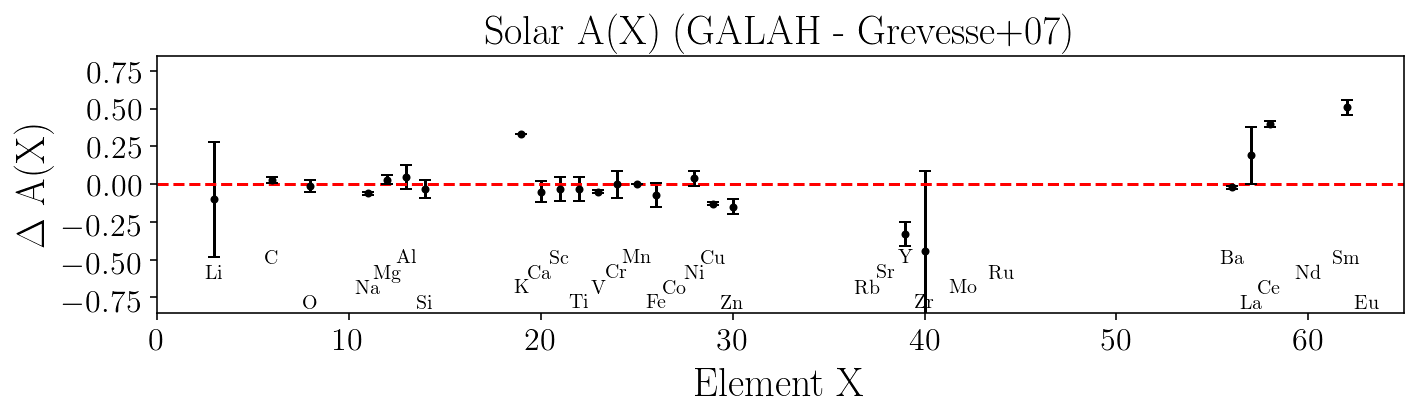

In [10]:
kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

f, (ax1) = plt.subplots(1, figsize=(10,3))

#ax1.set_title('Solar A(X) (GALAH - Asplund+09)', fontsize=20)
ax1.set_title('Solar A(X) (GALAH - Grevesse+07)', fontsize=20)
ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.851, 0.851)
ax1.set_xlim(0,65)
ax1.set_xlabel('Element X')
ax1.set_ylabel(r'$\Delta$ A(X)')
ax1.set_yticks([-0.75,-0.5, -0.25, 0.0, 0.25, 0.5,0.75])

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        ax1.errorbar(
            sun[each_key][2],
            float(galah_sun[each_key][0]) - float(sun[each_key][0]),
            yerr = np.sqrt(float(galah_sun[each_key][1])**2 + float(sun[each_key][1])**2),
            **kwargs_errorbar
            )
        ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:],ha='center')
plt.tight_layout()
plt.savefig('figures/abundance_zeropoints_sun.png', dpi=300, bbox_inches='tight')

In [12]:
for each_key in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age']:
    print(each_key,',',arcturus[each_key][0],'$\pm$',arcturus[each_key][1],',',galah_arcturus[each_key][0],'$\pm$',galah_arcturus[each_key][1])

teff , 4286 $\pm$ 35 , 4289 $\pm$ 21
logg , 1.6 $\pm$ 0.2 , 1.65 $\pm$ nan
fe_h , -0.52 $\pm$ 0.08 , -0.53 $\pm$ nan
fe_h_atmo , -0.52 $\pm$ 0.08 , -0.53 $\pm$ nan
vmic , 1.25 $\pm$ 0.0 , 1.57 $\pm$ nan
vbroad , 6.33600031566 $\pm$ 0.0 , 6.20 $\pm$ nan
mass , 1.08 $\pm$ 0.06 , 0.96 $\pm$ nan
lbol , 197.2 $\pm$ 2.2 , 179.87 $\pm$ nan
age , 7.1 $\pm$ 1.5 , 9.42 $\pm$ nan


In [14]:
for each_key in arcturus.keys():
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        print(each_key,',',arcturus[each_key][0],'$\pm$',arcturus[each_key][1],',',galah_arcturus[each_key][0],'$\pm$',galah_arcturus[each_key][1])

A_Li , 0.53 $\pm$ 0.03 , -1.13 $\pm$ 0.45
A_C , 8.03 $\pm$ 0.03 , nan $\pm$ nan
A_O , 8.63 $\pm$ 0.03 , 8.78 $\pm$ 0.07
A_Na , 5.76 $\pm$ 0.03 , 5.84 $\pm$ 0.00
A_Mg , 7.38 $\pm$ 0.03 , 7.44 $\pm$ 0.00
A_Al , 6.19 $\pm$ 0.03 , 6.27 $\pm$ 0.00
A_Si , 7.32 $\pm$ 0.03 , 7.27 $\pm$ 0.00
A_K , 4.76 $\pm$ 0.03 , 5.04 $\pm$ 0.00
A_Ca , 5.9 $\pm$ 0.03 , 5.88 $\pm$ 0.00
A_Sc , 2.8 $\pm$ 0.03 , 2.71 $\pm$ 0.00
A_Ti , 4.65 $\pm$ 0.03 , 4.63 $\pm$ 0.03
A_V , 3.54 $\pm$ 0.03 , 3.68 $\pm$ 0.00
A_Cr , 5.07 $\pm$ 0.03 , 5.02 $\pm$ 0.03
A_Mn , 4.66 $\pm$ 0.03 , 4.65 $\pm$ 0.00
A_Fe , 6.93 $\pm$ 0.03 , 6.83 $\pm$ 0.03
A_Co , 4.49 $\pm$ 0.03 , 4.55 $\pm$ 0.00
A_Ni , 5.77 $\pm$ 0.03 , 5.86 $\pm$ 0.00
A_Cu , 3.71 $\pm$ 0.03 , 3.71 $\pm$ 0.00
A_Zn , 4.08 $\pm$ 0.03 , 4.05 $\pm$ 0.00
A_Rb , 2.08 $\pm$ 0.03 , nan $\pm$ nan
A_Sr , 2.4 $\pm$ 0.03 , 1.80 $\pm$ 0.10
A_Y , 1.69 $\pm$ 0.03 , 1.35 $\pm$ 0.00
A_Zr , 2.06 $\pm$ 0.03 , 1.75 $\pm$ 0.00
A_Mo , 1.4 $\pm$ 0.03 , 1.76 $\pm$ 0.00
A_Ru , 1.32 $\pm$ 0.03 , 1.6

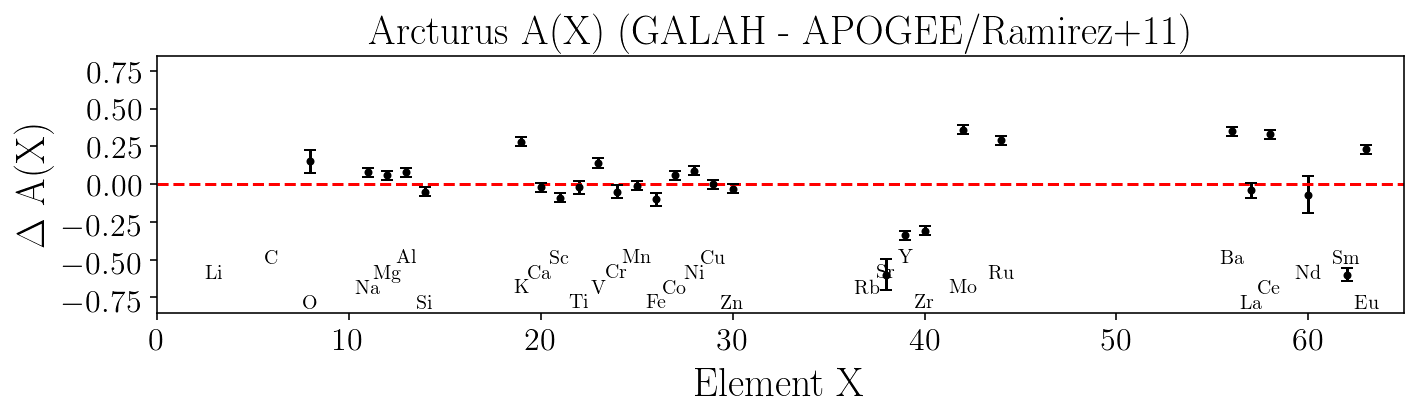

In [16]:
kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

f, (ax1) = plt.subplots(1, figsize=(10,3))
ax1.set_title('Arcturus A(X) (GALAH - APOGEE/Ramirez+11)', fontsize=20)

ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.851, 0.851)
ax1.set_xlim(0,65)
ax1.set_xlabel('Element X')
ax1.set_ylabel(r'$\Delta$ A(X)')
ax1.set_yticks([-0.75,-0.5, -0.25, 0.0, 0.25, 0.5,0.75])

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        ax1.errorbar(
            sun[each_key][2],
            float(galah_arcturus[each_key][0]) - float(arcturus[each_key][0]),
            yerr = np.sqrt(float(galah_arcturus[each_key][1])**2 + float(arcturus[each_key][1])**2),
            **kwargs_errorbar
            )
        ax1.text(arcturus[each_key][2], -.825 + it%4*0.1, each_key[2:],ha='center')

plt.tight_layout()
plt.savefig('figures/abundance_zeropoints_arcturus.png', dpi=300, bbox_inches='tight')

In [18]:
print('Element','Sun','Arcturus')
for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        print(each_key,float(galah_sun[each_key][0]) - float(sun[each_key][0]),float(galah_arcturus[each_key][0]) - float(arcturus[each_key][0]))

Element Sun Arcturus
A_Li -0.1 -1.66
A_C 0.03 nan
A_O -0.01 0.15
A_Na -0.06 0.08
A_Mg 0.03 0.06
A_Al 0.05 0.08
A_Si -0.03 -0.05
A_K 0.33 0.28
A_Ca -0.05 -0.02
A_Sc -0.03 -0.09
A_Ti -0.03 -0.02
A_V -0.05 0.14
A_Cr 0.0 -0.05
A_Mn 0.0 -0.01
A_Fe -0.07 -0.1
A_Co nan 0.06
A_Ni 0.04 0.09
A_Cu -0.13 0.0
A_Zn -0.15 -0.03
A_Rb nan nan
A_Sr nan -0.6
A_Y -0.33 -0.34
A_Zr -0.44 -0.31
A_Mo nan 0.36
A_Ru nan 0.29
A_Ba -0.02 0.35
A_La 0.19 -0.04
A_Ce 0.4 0.33
A_Nd nan -0.07
A_Sm 0.51 -0.6
A_Eu nan 0.23


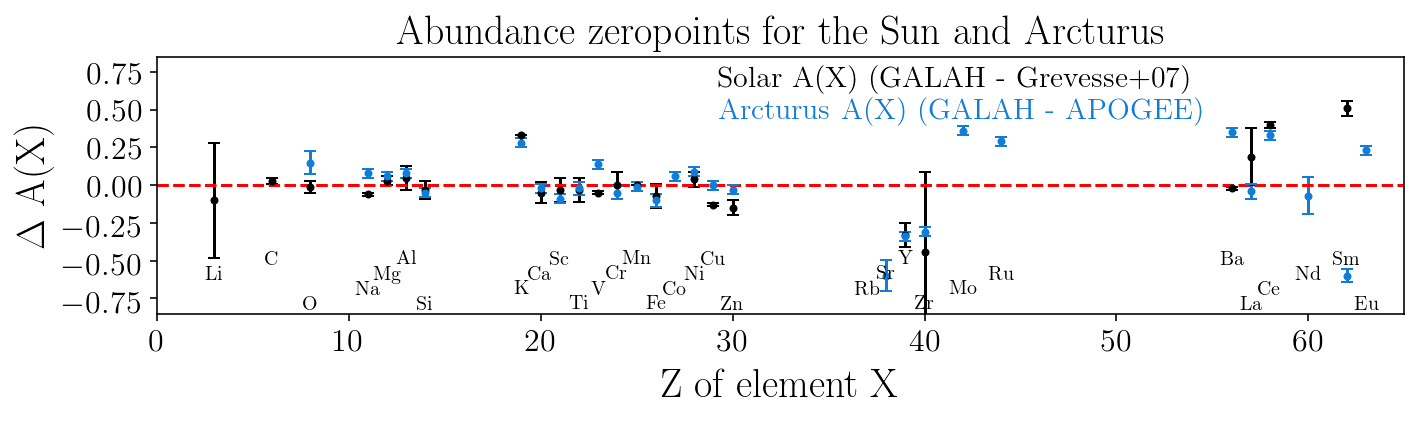

In [20]:
kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

f, (ax1) = plt.subplots(1, figsize=(10,3))

ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.651, 0.651)
ax1.set_xlim(0,65)

#ax1.text(0.45,0.975,'Solar A(X) (GALAH - Asplund+09)', fontsize=15, color='k',transform=ax1.transAxes,ha='left',va='top')
ax1.text(0.45,0.975,'Solar A(X) (GALAH - Grevesse+07)', fontsize=15, color='k',transform=ax1.transAxes,ha='left',va='top')
ax1.text(0.45,0.85,'Arcturus A(X) (GALAH - APOGEE)', fontsize=15, color=willi_blau,transform=ax1.transAxes,ha='left',va='top')

ax1.set_yticks([-0.75,-0.5, -0.25, 0.0, 0.25, 0.5,0.75])

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        ax1.errorbar(
            sun[each_key][2],
            float(galah_sun[each_key][0]) - float(sun[each_key][0]),
            yerr = np.sqrt(float(galah_sun[each_key][1])**2 + float(sun[each_key][1])**2),
            **kwargs_errorbar
            )
        ax1.text(sun[each_key][2], -.825 + it%4*0.1, each_key[2:],ha='center')

kwargs_errorbar = dict(color = willi_blau, capsize=3, fmt='o', ms=3)

ax1.set_title('Abundance zeropoints for the Sun and Arcturus', fontsize=20)

ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.851, 0.851)
ax1.set_xlim(0,65)
ax1.set_xlabel('Z of element X')
ax1.set_ylabel(r'$\Delta$ A(X)')

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['teff','logg','fe_h','fe_h_atmo','vmic','vbroad','mass','lbol','age','alpha_fe']:
        ax1.errorbar(
            sun[each_key][2],
            float(galah_arcturus[each_key][0]) - float(arcturus[each_key][0]),
            yerr = np.sqrt(float(galah_arcturus[each_key][1])**2 + float(arcturus[each_key][1])**2),
            **kwargs_errorbar
            )

plt.tight_layout()
plt.savefig('figures/abundance_zeropoints.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/abundance_zeropoints.pdf', dpi=300, bbox_inches='tight')

In [21]:
galah_sun['A_Co'][0:2] = np.array(sun["A_Co"][0:2])
galah_sun['A_Co7713'][0:2] = np.array(sun["A_Co"][0:2])
galah_sun['A_Eu'][0:2] = np.array(sun["A_Eu"][0:2])
galah_sun['A_Eu5819'][0:2] = np.array(sun["A_Eu"][0:2])
galah_sun['A_Eu6645'][0:2] = np.array(sun["A_Eu"][0:2])
galah_sun['A_K5802'][0:2] = np.array(sun["A_K"][0:2])
galah_sun['A_Mo'][0:2] = np.array(sun["A_Mo"][0:2])
galah_sun['A_Na4752'][0:2] = np.array(sun["A_Na"][0:2])
galah_sun['A_Nd'][0:2] = np.array(sun["A_Nd"][0:2])
galah_sun['A_Nd4811'][0:2] = np.array(sun["A_Nd"][0:2])
galah_sun['A_Rb'][0:2] = np.array(sun["A_Rb"][0:2])
galah_sun['A_Ru'][0:2] = np.array(sun["A_Ru"][0:2])
galah_sun['A_Sr'][0:2] = np.array(sun["A_Sr"][0:2])
galah_sun['A_Y4855'][0:2] = np.array(sun["A_Y"][0:2])
galah_sun['A_Y5663'][0:2] = np.array(sun["A_Y"][0:2])
galah_sun['A_Y5729'][0:2] = np.array(sun["A_Y"][0:2])

In [22]:
sun_pandas = pandas.DataFrame(galah_sun,columns=galah_sun.keys())
sun_astropy = Table.from_pandas(sun_pandas)
sun_astropy.write('galahdr3_abundance_zeropoints.fits',overwrite=True)
sun_pandas

,teff,logg,fe_h,fe_h_atmo,vmic,vbroad,mass,lbol,age,alpha_fe,...,A_Ba,A_Ba6497,A_La,A_Ce,A_Nd4811,A_Nd,A_Sm,A_Eu,A_Eu5819,A_Eu6645
0,5779.0,4.42,0.01,0.01,1.16,6.52,0.97,1.01,5.83,0.0,...,2.15,2.31,1.32,2.10,1.45,1.45,1.51,0.52,0.52,0.52
1,104.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.01,0.01,0.19,0.02,0.00,0.00,0.05,0.00,0.00,0.00
